In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np

In [2]:
# time.sleep(30)

In [3]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines

for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "MAKWest.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com


## Set number of clusters

In [4]:
nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)


total_count = 8


nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = 2

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]




# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



2


In [5]:
clientIps, no_cluster_yet_nodes

(['127.0.0.1', '127.0.0.1'], [])

## Functions

In [6]:
def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
        os.system(command)

        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ./gradlew installDist'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S rm ../dump_files/nohup*.out; echo 1234 | sudo -S rm config*/currentView;'
        
        
        os.system(command)
        
        

        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 & echo $! > ../dump_files/jobID_s'+str(i)+'.txt'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)        
#         print(command)



def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(i-len(nodeIps)-len(no_cluster_yet_nodes))+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = ' killall java; killall nohup'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'killall java;  killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = ' nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        print(command)

# for i in range(len(lines)):
#     run_basic_client_check(i)



def join_node1(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11080 11081 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)   
        
        
def join_node2(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11090 11091 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command) 
        
def join_node3(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11100 11101 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command) 

## Compile Job

## Setup Client and nodeIPS

In [7]:
len(lines)

10

In [8]:
len(nodeIps), len(clientIps)

(8, 2)

## RUN SERVERS

In [9]:
for i in range(len(lines)):
    kill_java(i)

for i in range(len(lines)):
    clean_job(i)
    
compile_job(1)



java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
java: no process found
nohup: no process found
java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
java: no process found
nohup: no process found
java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
java: no process found
nohup: no process found
java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
java: no process found
nohup: no process found
java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
java: no process found
nohup: no process found
java(4449): Operation not permitted
java(5679

> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE
> Task :jar UP-TO-DATE
> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 1s
3 actionable tasks: 3 up-to-date


In [10]:
    
for i in range(len(lines)-nclients-len(no_cluster_yet_nodes)):
    print(i)
    run_server_node(i)

0
1
2
3
4
5
6
7


In [11]:
time.sleep(30)
!tail ../dump_files/nohup_s0.out -n 50

-- smsg.getSender() 1, smsg.getState().getLastCID() -1
-- Received 1 replies for query ID 7
-- <-- receiving, msg:bftsmart.statemanagement.standard.StandardSMMessage@33305e43 with it being OtherClusterMessage=false
-- currentConsensusIdReceived activated
-- Received  CID reply from replica ( or smsg.getSender()) 2 with smsg.getCID() 7 (expecting queryID 7),  waitingCID -1, isInitializing true
-- smsg.getSender() 2, smsg.getState().getLastCID() -1
-- Received 2 replies for query ID 7
-- Tejas: Sending CID query with ID 7 to replicas [1, 2, 3]
-- --> 3: sending SystemMessage message from: bftsmart.statemanagement.standard.StandardSMMessage@6e9a5ed8 -> [1, 2, 3]
-- Sending message from:0 -> to:2.
-- Sending message from:0 -> to:3.
-- Sending message from:0 -> to:1.
-- <-- receiving, msg:bftsmart.statemanagement.standard.StandardSMMessage@68e4c8e4 with it being OtherClusterMessage=false
-- currentConsensusIdReceived activated
-- Received  CID reply from replica ( or smsg.getSender()) 2 wit

In [12]:


# for i in range(len(lines)):
#     kill_java(i)

In [13]:
len(nodeIps)+len(no_cluster_yet_nodes)+len(clientIps)


10

## Run basic client

In [14]:
for i in range(len(nodeIps)+len(no_cluster_yet_nodes),len(nodeIps)+len(no_cluster_yet_nodes)+len(clientIps)):
    run_basic_client(i)

In [15]:
time.sleep(250)

In [16]:

# time.sleep(30)
# run_server_node(8)
# time.sleep(15)
# join_node1(8)

# time.sleep(30)
# run_server_node(9)

# time.sleep(30)
# join_node2(9)

# time.sleep(30)
# run_server_node(10)
# time.sleep(30)
# join_node3(10)

In [17]:
# time.sleep(50)

# run_server_node(9)

# time.sleep(160)
# join_node2(9)


# for i in [2]:
#     os.system('kill -9 `cat ../dump_files/jobID_s2.txt`')
    


# time.sleep(80)



for i in range(len(lines)):
    kill_java(i)
    


java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
nohup: no process found
java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
nohup: no process found
java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
nohup: no process found
java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
nohup: no process found
java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
nohup: no process found
java(4449): Operation not permitted
java(5679): Operation not permitted
java(5969): Operation not permitted
java(6055): Operation not permitted
nohup: no proces

In [18]:
# for i in range(len(lines)):
#     kill_java(i)

## Main Job

In [19]:

def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
#         print(line)
        if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())


            read_lat = '0'
            write_lat = '0'

            if ('READ AverageLatency' in line):

                print(line)

                read_lat = line.split('READ AverageLatency(us)=')[1].split(']')[0].strip()


            if ('UPDATE AverageLatency' in line):                    

                write_lat = line.split('UPDATE AverageLatency(us)=')[1].split(']')[0].strip()


            if (('READ AverageLatency' not in line) and ('UPDATE AverageLatency' not in line)):
                latencies.append(line.split('=')[1].split(']')[0].strip())
            else:
                read_frac = 0
                write_frac = 0

                if float(read_lat) > 0:
                    read_frac = 0.85

                if float(write_lat) > 0:
                    write_frac = 0.15

#                         print(line, write_frac, read_frac, float(read_lat), float(write_lat))

                lat = str( (write_frac * float(write_lat) +\
                            read_frac*float(read_lat))/(write_frac+read_frac)\
                         )
                latencies.append(lat)

            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  


In [20]:
## Byzantine Remote View Change

In [21]:
times ,thputs, lats = getTimesThputs('../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes))+'.out')
times2 ,thputs2, lats = getTimesThputs('../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes)+1)+'.out')


'../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes))+'.out'

 3 sec: 1 operations; 1 current ops/sec; [UPDATE AverageLatency(us)=985141] 
 985141.0 1 3
 4 sec: 8 operations; 6.91 current ops/sec; [UPDATE AverageLatency(us)=180339.86] 
 180339.86 6.91 4
 5 sec: 14 operations; 5.98 current ops/sec; [UPDATE AverageLatency(us)=176979.17] 
 176979.17 5.98 5
 6 sec: 20 operations; 5.99 current ops/sec; [UPDATE AverageLatency(us)=159650.33] 
 159650.33 5.99 6
 7 sec: 24 operations; 4 current ops/sec; [UPDATE AverageLatency(us)=234664.25] 
 234664.25 4 7
 8 sec: 30 operations; 5.96 current ops/sec; [UPDATE AverageLatency(us)=169848.17] 
 169848.17 5.96 8
 9 sec: 34 operations; 4 current ops/sec; [UPDATE AverageLatency(us)=229528.75] 
 229528.75 4 9
 10 sec: 41 operations; 6.99 current ops/sec; [UPDATE AverageLatency(us)=164386] 
 164386.0 6.99 10
 11 sec: 47 operations; 5.99 current ops/sec; [UPDATE AverageLatency(us)=140835] 
 140835.0 5.99 11
 12 sec: 54 operations; 6.94 current ops/sec; [UPDATE AverageLatency(us)=157380.71] 
 157380.71 6.94 12
 13 se

'../dump_files/nohup_c8.out'

In [22]:
# times - times2

In [23]:
# thputs = thputs + thputs2

In [24]:
# np.mean(lats[20:]) # 23604.83205128205

In [25]:
np.mean(lats[20:])

0.0739257317874396

In [26]:
lats

array([ 1.174814  ,  0.17180533,  0.16616917,  0.15318529,  0.259112  ,
        0.1649404 ,  0.2063418 ,  0.1760155 ,  0.133058  ,  0.16007386,
        0.1302475 ,  0.10654367,  0.08449408,  0.08004725,  0.08494567,
        0.077357  ,  0.07249977,  0.07819407,  0.08950164,  0.06118219,
        0.06063331,  0.07583321,  0.07237364,  0.03711927,  0.04464639,
        0.03003494,  0.03358807,  0.035112  ,  0.04407486,  0.05097405,
        0.04401078,  0.02945329,  0.05687835,  0.03632071,  0.04334891,
        0.03299719,  0.03148681,  0.03039645,  0.03261803,  0.03524707,
        0.02966612,  0.02374057,  0.03149134,  0.02715814,  0.0317168 ,
        0.0291485 ,  0.03119519,  0.02179428,  0.02694165,  0.02219089,
        0.02841182,  0.03022538,  0.02786874,  0.0214615 ,  0.02560092,
        0.02111661,  0.02365447,  0.02925485,  0.06063453,  0.03446397,
        0.02729986,  0.01965265,  0.02073387,  0.02307111,  0.02469875,
        0.0281464 ,  0.03330945,  0.02028519,  0.02922054,  0.02

In [27]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


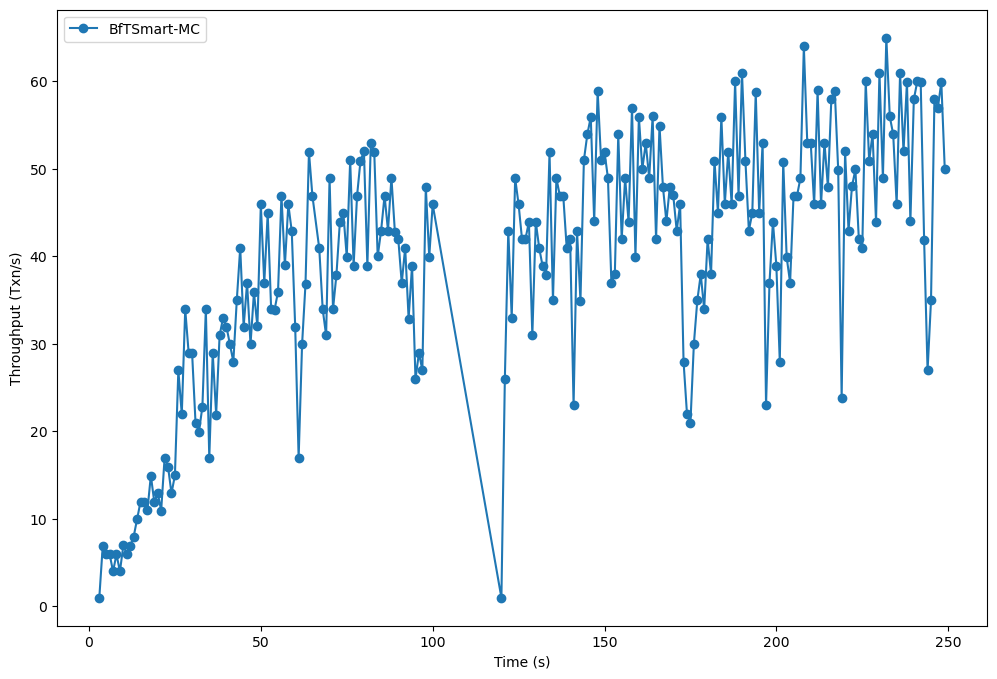

<Figure size 640x480 with 0 Axes>

In [28]:
import pylab as pl

pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
pl.show()
pl.clf()


In [38]:
times_new = [x for x in range(250)]
thputs_new = [0 for x in range(250)]
for idx, t in enumerate(times):
    thputs_new[int(t)] = thputs[idx]
    

times_new, thputs_new

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

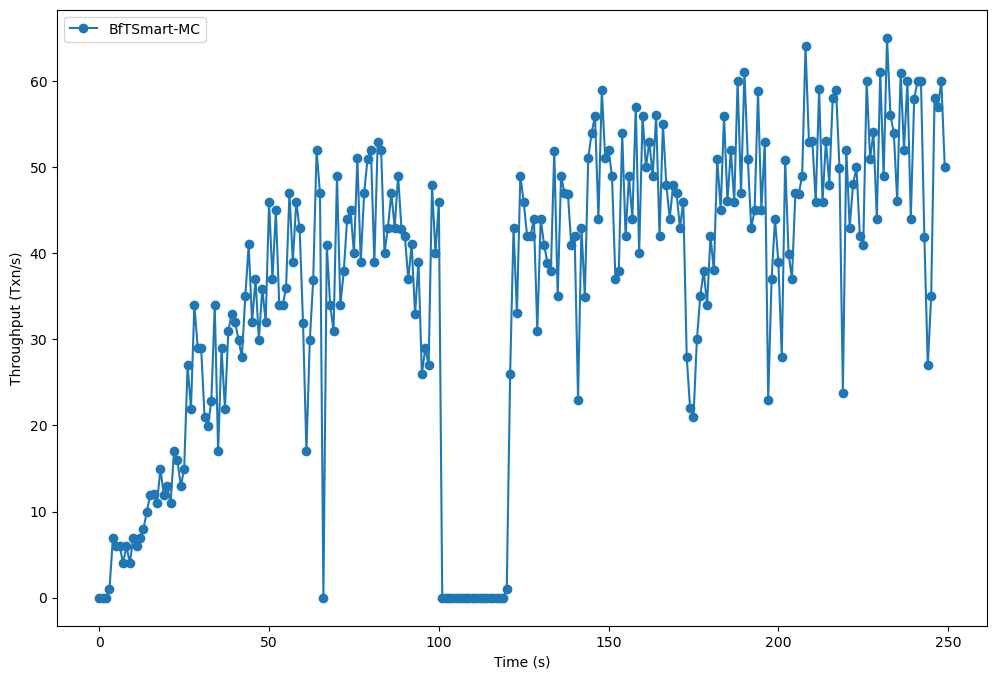

<Figure size 640x480 with 0 Axes>

In [39]:
import pylab as pl

pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
pl.plot(times_new[:], thputs_new[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
pl.show()
pl.clf()


In [29]:
(thputs), np.sum(thputs)

(array([ 1.  ,  6.91,  5.98,  5.99,  4.  ,  5.96,  4.  ,  6.99,  5.99,
         6.94,  7.99,  9.99, 11.98, 11.99, 10.98, 14.96, 11.93, 12.97,
        10.96, 16.98, 15.98, 12.92, 14.99, 26.97, 21.96, 33.97, 28.97,
        28.97, 20.98, 19.98, 22.84, 33.97, 16.98, 28.97, 21.93, 30.97,
        32.97, 31.97, 29.97, 27.97, 34.97, 41.  , 31.97, 36.96, 29.97,
        35.89, 32.  , 45.95, 36.96, 44.96, 33.97, 33.93, 35.96, 46.95,
        39.  , 45.95, 42.87, 31.94, 16.98, 29.94, 36.89, 51.95, 46.95,
        40.92, 33.97, 30.97, 48.95, 33.97, 37.92, 43.96, 44.96, 39.96,
        51.  , 38.96, 46.95, 50.95, 52.  , 38.92, 52.95, 51.95, 40.  ,
        42.96, 46.95, 42.96, 49.  , 42.83, 41.96, 36.96, 41.  , 32.9 ,
        38.96, 25.97, 28.97, 27.  , 47.95, 39.96, 45.95,  1.  , 25.97,
        42.96, 33.  , 48.95, 45.95, 41.96, 42.  , 43.96, 30.97, 43.96,
        40.96, 38.88, 37.92, 51.9 , 35.  , 48.95, 46.95, 46.91, 40.96,
        42.  , 22.98, 42.96, 34.93, 51.  , 53.95, 55.94, 44.  , 58.94,
      

In [30]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()
